# Training process 3
+ Model name：`Formal_training_process3_model_resnet50_light_focalloss.pt` ; 
+ Path： `/model/Formal_training_process3_model_resnet50_light_focalloss.pt`
+ Training network：`resnet50 with 1 fully connected layers`
+ Loss function：`Focalloss`
+ Optimizer： `Adam`
+ epoch： `50`
+ sample pairing: `False ` 

### Data Preparation

In [1]:
import torch
import torchvision
from torchvision import datasets,transforms 
from face_crop import face_crop

train_dir = r'D:\Jupyterlab_workspace\nn_facerecognition\lfw\lfw_train'
valid_dir = r'D:\Jupyterlab_workspace\nn_facerecognition\lfw\lfw_val'

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
    transforms.RandomErasing(),
])


valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                           shuffle=True, num_workers=4)


valid_data = datasets.ImageFolder(root=valid_dir,
                                transform=valid_transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64,
                                          shuffle=True, num_workers=4)


In [2]:
train_data

Dataset ImageFolder
    Number of datapoints: 10481
    Root location: D:\Jupyterlab_workspace\nn_facerecognition\lfw\lfw_train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomErasing()
           )

In [3]:
valid_data

Dataset ImageFolder
    Number of datapoints: 6821
    Root location: D:\Jupyterlab_workspace\nn_facerecognition\lfw\lfw_val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
class_names = train_data.classes

C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


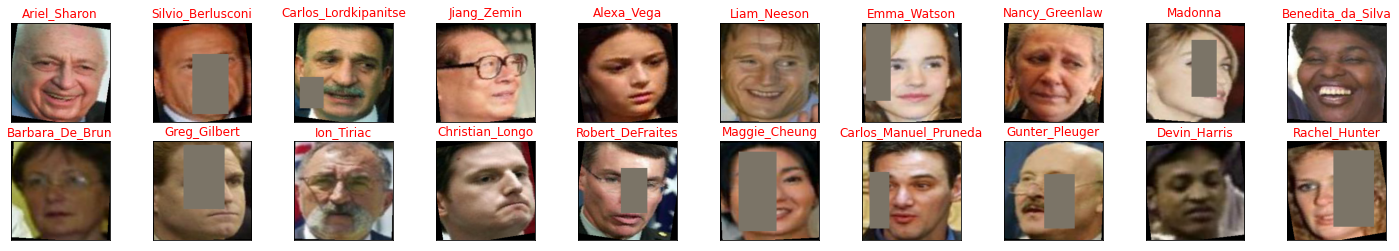

In [5]:
#Transform Data visualize
import numpy as np
import matplotlib.pyplot as plt
images, classes = next(iter(train_loader))

def imshow(inp):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    

fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]], color='red') 

## Training Network

In [5]:
# Resnet50 with Two fully connected layers
from torchvision import models
from torch import nn
from collections import OrderedDict

model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc', nn.Linear(2048, len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the classifier part of the introduced net!
model_resnet50.fc = classifier

In [6]:
#model_resnet50

## Trainning process

In [7]:
import torch 
import torch.nn.functional as F
from torch import nn, optim  
from tqdm import tqdm
import numpy as np
from focal_loss import FocalLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model='resnet50', data_augumentation=False, loss='NLLLoss', lr=0.003, weight_decay=1e-5, epoch=None):
    if model == 'model_resnet50':
        model = model_resnet50
    
    model.to(device)
    
    if data_augumentation:
        pass
        
    if loss == 'NLLLoss':
        criterion = nn.NLLLoss()
        
    if loss == 'FocalLoss':
        print('use focal loss')
        criterion = FocalLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)    
    
    epochs = epoch
    train_losses, valid_losses = [], []
    valid_loss_min = np.inf

    for e in range(epochs):
        train_loss = 0 
        valid_loss = 0
        accuracy = 0.0

        model.train()
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss = loss.requires_grad_()
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()  # Close dropout
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                
                # Verify loss
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item() * images.size(0)
                
                # Verify accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # An epoch loss
        train_loss = train_loss/len(train_loader.sampler)   
        valid_loss = valid_loss/len(valid_loader.sampler)
        valid_accuracy = accuracy / len(valid_loader)

        # Add the loss to the list for graphing
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # Add the code to save this list to the local to use this loss transformation list when not training in the future, 
        # such as comparing different models
        train_loss_array = np.array(train_losses)
        valid_loss_array = np.array(valid_losses)
        valid_accuracy_array = np.array(valid_accuracy)
        
        
        np.save('./results/Ftp3_train_loss_array_resnet50_light_focalloss.npy', train_loss_array)
        np.save('./results/Ftp3_valid_loss_array_resnet50_light_focalloss.npy', valid_loss_array)
        np.save('./results/Ftp3_valid_accuracy_array_resnet50_light_focalloss.npy', valid_accuracy_array)
        
   
        # Print an epoch information
        print('Epoch {}/{}..'.format(e + 1, epochs),
              'Train loss:{:.4f}..'.format(train_loss),
              'Valid loss:{:.4f}..'.format(valid_loss),
              'Valid accuracy:{:.4f}%..'.format(valid_accuracy * 100))
        
        # Save the optimal model
        if valid_loss <= valid_loss_min:
            print('valid_loss decreased: ({:.4f} --> {:.4f}), saving model "Formal_training_process3_model_resnet50_light_focalloss"..'.format(valid_loss_min, valid_loss))
            torch.save(model, './model/Formal_training_process3_model_resnet50_light_focalloss.pt')
            valid_loss_min = valid_loss

In [8]:
train(model='model_resnet50', data_augumentation=False, loss='FocalLoss', lr=0.001, weight_decay=1e-5, epoch=50)

  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

use focal loss


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:28<00:00,  1.95s/it]


Epoch 1/50.. Train loss:10.0419.. Valid loss:8.5650.. Valid accuracy:2.0697%..
valid_loss decreased: (inf --> 8.5650), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:23<00:00,  1.90s/it]


Epoch 2/50.. Train loss:8.1149.. Valid loss:8.0864.. Valid accuracy:3.1795%..
valid_loss decreased: (8.5650 --> 8.0864), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:31<00:00,  1.98s/it]


Epoch 3/50.. Train loss:7.4630.. Valid loss:7.5270.. Valid accuracy:4.1314%..
valid_loss decreased: (8.0864 --> 7.5270), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:31<00:00,  1.98s/it]


Epoch 4/50.. Train loss:6.8578.. Valid loss:6.9480.. Valid accuracy:7.3772%..
valid_loss decreased: (7.5270 --> 6.9480), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:35<00:00,  2.02s/it]


Epoch 5/50.. Train loss:6.3357.. Valid loss:6.4492.. Valid accuracy:10.5606%..
valid_loss decreased: (6.9480 --> 6.4492), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:27<00:00,  1.94s/it]


Epoch 6/50.. Train loss:5.8465.. Valid loss:5.9840.. Valid accuracy:15.5323%..
valid_loss decreased: (6.4492 --> 5.9840), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:30<00:00,  1.96s/it]


Epoch 7/50.. Train loss:5.3875.. Valid loss:5.5910.. Valid accuracy:18.7634%..
valid_loss decreased: (5.9840 --> 5.5910), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:14<00:00,  1.82s/it]


Epoch 8/50.. Train loss:4.9593.. Valid loss:5.1942.. Valid accuracy:25.6188%..
valid_loss decreased: (5.5910 --> 5.1942), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:35<00:00,  2.01s/it]


Epoch 9/50.. Train loss:4.5607.. Valid loss:4.8368.. Valid accuracy:29.8963%..
valid_loss decreased: (5.1942 --> 4.8368), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:40<00:00,  2.06s/it]


Epoch 10/50.. Train loss:4.1842.. Valid loss:4.5215.. Valid accuracy:34.7645%..
valid_loss decreased: (4.8368 --> 4.5215), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:32<00:00,  1.98s/it]


Epoch 11/50.. Train loss:3.8816.. Valid loss:4.1974.. Valid accuracy:40.3041%..
valid_loss decreased: (4.5215 --> 4.1974), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:26<00:00,  1.93s/it]


Epoch 12/50.. Train loss:3.5546.. Valid loss:3.9502.. Valid accuracy:44.2868%..
valid_loss decreased: (4.1974 --> 3.9502), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:23<00:00,  1.90s/it]


Epoch 13/50.. Train loss:3.2514.. Valid loss:3.7745.. Valid accuracy:45.2190%..
valid_loss decreased: (3.9502 --> 3.7745), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:15<00:00,  1.82s/it]


Epoch 14/50.. Train loss:3.0173.. Valid loss:3.6221.. Valid accuracy:47.7476%..
valid_loss decreased: (3.7745 --> 3.6221), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:17<00:00,  1.85s/it]


Epoch 15/50.. Train loss:2.7411.. Valid loss:3.4295.. Valid accuracy:50.7972%..
valid_loss decreased: (3.6221 --> 3.4295), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:18<00:00,  1.85s/it]


Epoch 16/50.. Train loss:2.5565.. Valid loss:3.2984.. Valid accuracy:52.0503%..
valid_loss decreased: (3.4295 --> 3.2984), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:19<00:00,  1.86s/it]


Epoch 17/50.. Train loss:2.3325.. Valid loss:3.1358.. Valid accuracy:55.8088%..
valid_loss decreased: (3.2984 --> 3.1358), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:19<00:00,  1.86s/it]


Epoch 18/50.. Train loss:2.1389.. Valid loss:3.0207.. Valid accuracy:56.7552%..
valid_loss decreased: (3.1358 --> 3.0207), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:17<00:00,  1.85s/it]


Epoch 19/50.. Train loss:2.0031.. Valid loss:2.9618.. Valid accuracy:57.5039%..
valid_loss decreased: (3.0207 --> 2.9618), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:50<00:00,  2.15s/it]


Epoch 20/50.. Train loss:1.8550.. Valid loss:2.9049.. Valid accuracy:58.8619%..
valid_loss decreased: (2.9618 --> 2.9049), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:16<00:00,  1.84s/it]


Epoch 21/50.. Train loss:1.7883.. Valid loss:2.8470.. Valid accuracy:59.3797%..
valid_loss decreased: (2.9049 --> 2.8470), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:16<00:00,  1.84s/it]


Epoch 22/50.. Train loss:1.6228.. Valid loss:2.7963.. Valid accuracy:60.9276%..
valid_loss decreased: (2.8470 --> 2.7963), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:17<00:00,  1.85s/it]


Epoch 23/50.. Train loss:1.5236.. Valid loss:2.7818.. Valid accuracy:60.4497%..
valid_loss decreased: (2.7963 --> 2.7818), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:18<00:00,  1.85s/it]


Epoch 24/50.. Train loss:1.4507.. Valid loss:2.7051.. Valid accuracy:62.1397%..
valid_loss decreased: (2.7818 --> 2.7051), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:17<00:00,  1.85s/it]


Epoch 25/50.. Train loss:1.3235.. Valid loss:2.6614.. Valid accuracy:62.6815%..
valid_loss decreased: (2.7051 --> 2.6614), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 26/50.. Train loss:1.2546.. Valid loss:2.6874.. Valid accuracy:61.8145%..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:16<00:00,  1.83s/it]


Epoch 27/50.. Train loss:1.2288.. Valid loss:2.6106.. Valid accuracy:62.8142%..
valid_loss decreased: (2.6614 --> 2.6106), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 28/50.. Train loss:1.1577.. Valid loss:2.6238.. Valid accuracy:62.8501%..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:16<00:00,  1.84s/it]


Epoch 29/50.. Train loss:1.0871.. Valid loss:2.5846.. Valid accuracy:64.0262%..
valid_loss decreased: (2.6106 --> 2.5846), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 30/50.. Train loss:1.0455.. Valid loss:2.5932.. Valid accuracy:63.2708%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 31/50.. Train loss:0.9858.. Valid loss:2.5864.. Valid accuracy:63.4314%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 32/50.. Train loss:0.9564.. Valid loss:2.5866.. Valid accuracy:63.7673%..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:36<00:00,  2.03s/it]


Epoch 33/50.. Train loss:0.9079.. Valid loss:2.5706.. Valid accuracy:64.2772%..
valid_loss decreased: (2.5846 --> 2.5706), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 34/50.. Train loss:0.9029.. Valid loss:2.6188.. Valid accuracy:63.4287%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 35/50.. Train loss:0.8437.. Valid loss:2.5714.. Valid accuracy:64.1935%..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:23<00:00,  1.90s/it]


Epoch 36/50.. Train loss:0.8277.. Valid loss:2.5463.. Valid accuracy:64.1324%..
valid_loss decreased: (2.5706 --> 2.5463), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 37/50.. Train loss:0.8035.. Valid loss:2.5556.. Valid accuracy:64.8878%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 38/50.. Train loss:0.7942.. Valid loss:2.5773.. Valid accuracy:64.2160%..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:26<00:00,  1.93s/it]


Epoch 39/50.. Train loss:0.7752.. Valid loss:2.5196.. Valid accuracy:65.4506%..
valid_loss decreased: (2.5463 --> 2.5196), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 40/50.. Train loss:0.7229.. Valid loss:2.5658.. Valid accuracy:64.9063%..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:34<00:00,  2.01s/it]


Epoch 41/50.. Train loss:0.6547.. Valid loss:2.5109.. Valid accuracy:65.4758%..
valid_loss decreased: (2.5196 --> 2.5109), saving model "Formal_training_process3_model_resnet50_light_focalloss"..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 42/50.. Train loss:0.6612.. Valid loss:2.5729.. Valid accuracy:65.0034%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 43/50.. Train loss:0.6702.. Valid loss:2.5737.. Valid accuracy:64.7244%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 44/50.. Train loss:0.6326.. Valid loss:2.5639.. Valid accuracy:65.3791%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 45/50.. Train loss:0.6207.. Valid loss:2.6033.. Valid accuracy:64.8199%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 46/50.. Train loss:0.5913.. Valid loss:2.5893.. Valid accuracy:65.0219%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 47/50.. Train loss:0.6129.. Valid loss:2.5894.. Valid accuracy:64.8586%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 48/50.. Train loss:0.5933.. Valid loss:2.6116.. Valid accuracy:64.6356%..


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

Epoch 49/50.. Train loss:0.6127.. Valid loss:2.5779.. Valid accuracy:65.0192%..


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [03:43<00:00,  2.09s/it]

Epoch 50/50.. Train loss:0.6133.. Valid loss:2.5887.. Valid accuracy:65.0444%..


### Loss visualization

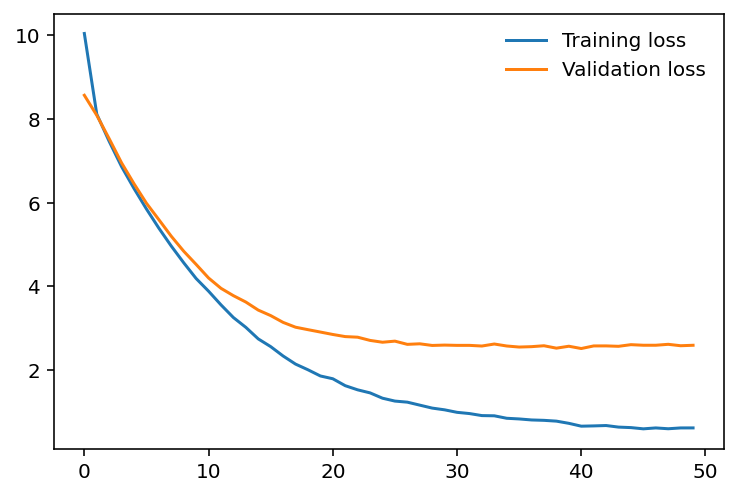

In [9]:
train_losses = np.load('./results/Ftp3_train_loss_array_resnet50_light_focalloss.npy')
valid_losses = np.load('./results/Ftp3_valid_loss_array_resnet50_light_focalloss.npy')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False) 

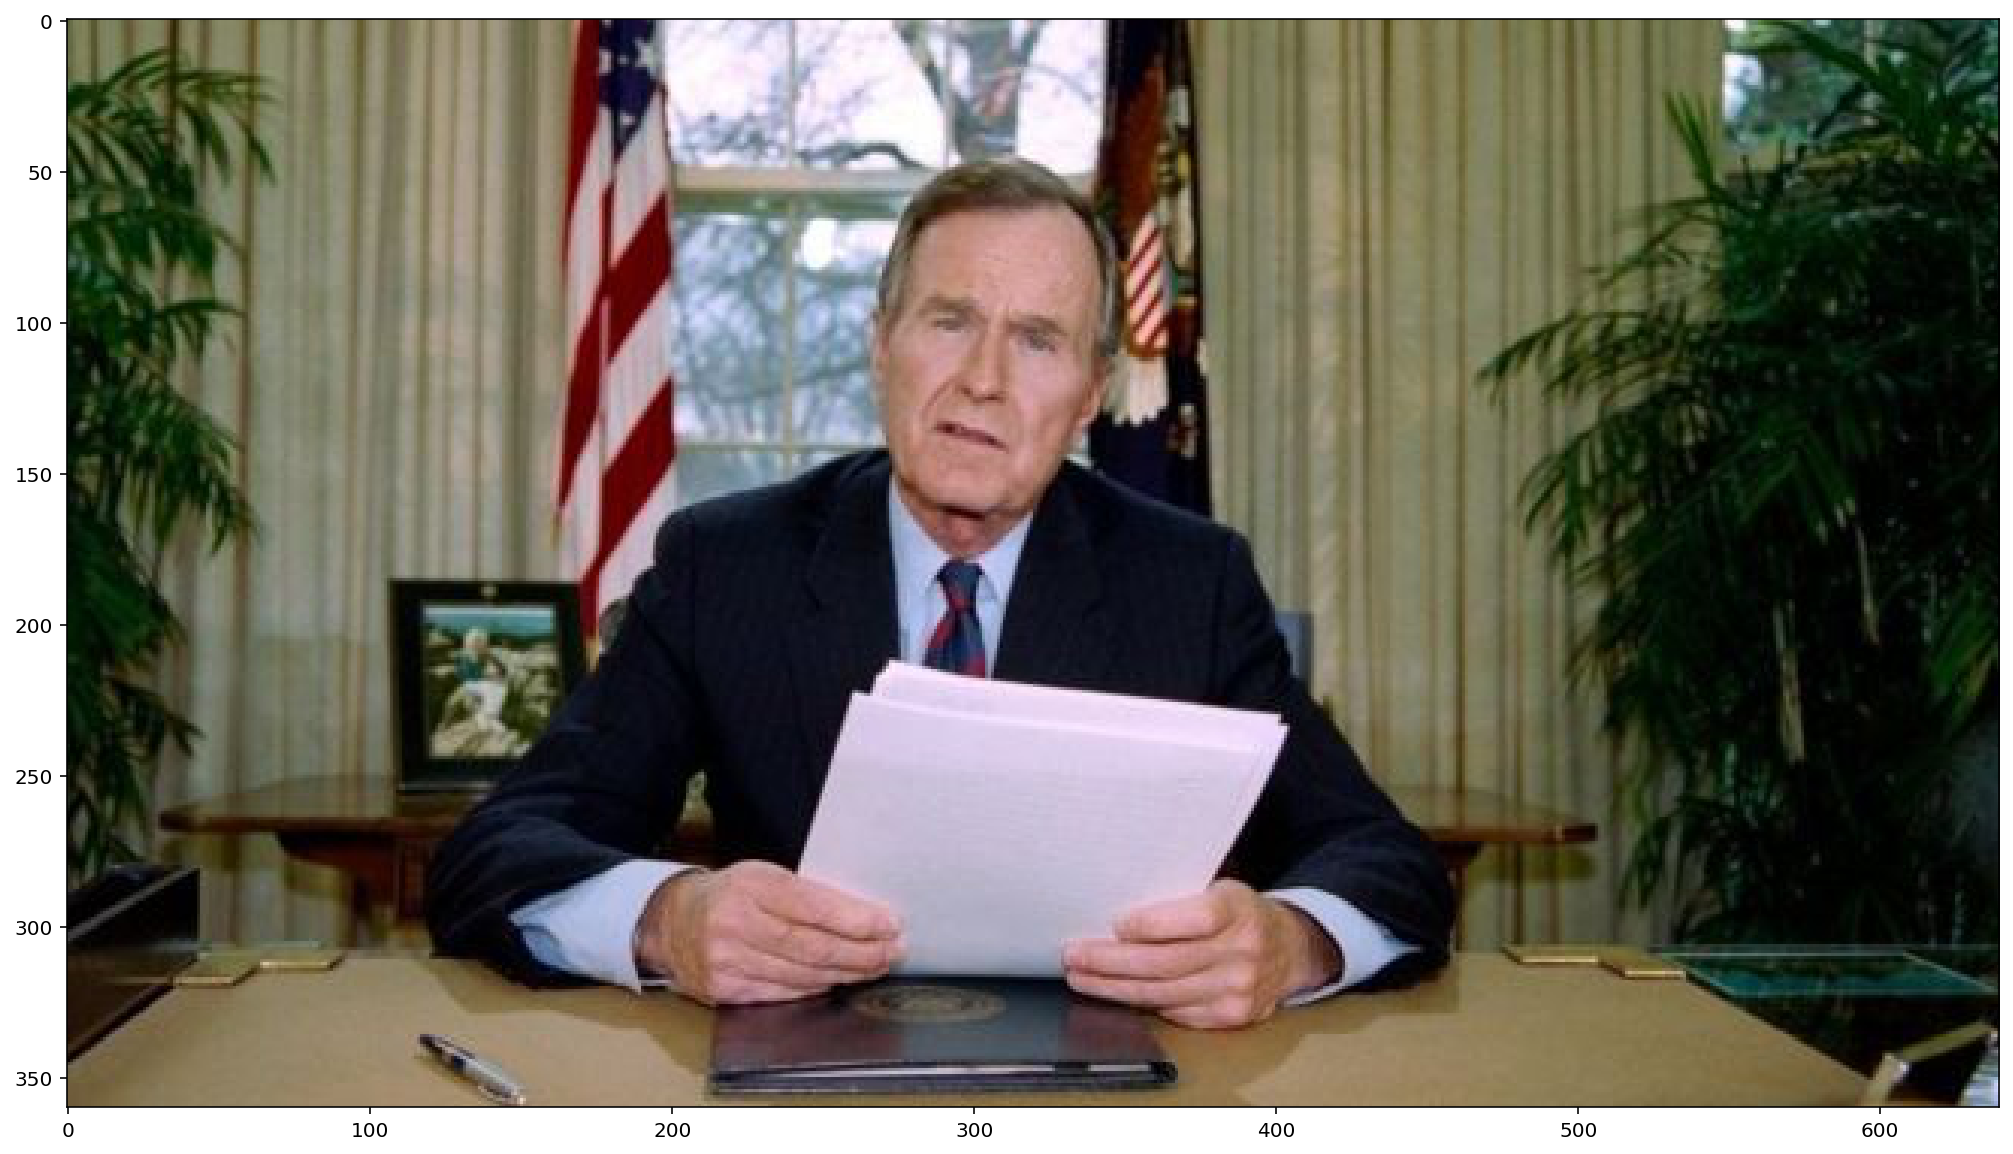

In [10]:
img_path = './data/face_test/big_bushi.jpg'

# Read test picture
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(48, 10)) # Set canvas size

img = Image.open(img_path)
plt.imshow(img)

In [11]:
model_path = './model/Formal_training_process3_model_resnet50_light_focalloss.pt'
# Load model
import torch
model=torch.load(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)

In [12]:
img_path = './data/face_test/big_bushi.jpg'
img = Image.open(img_path)
trans = transforms.ToPILImage()
trans1 = transforms.ToTensor()
transformed_image = valid_transform(img).float()
with torch.no_grad():
    transformed_image = transformed_image

transformed_image = transformed_image.unsqueeze(0)
transformed_image = transformed_image.to(device)
outputs = model(transformed_image)
outputs = torch.exp(outputs)

In [13]:
top_p, top_k = torch.topk(outputs, 10, dim=1, largest=True, sorted=True, out=None)

In [14]:
class_names = train_data.classes

In [15]:
print('The most similar person is {}.'.format(class_names[top_k[0][0].item()]))
print('Similarity is {:.2%}'.format(top_p[0][0].item()))
print('\n')
print('The second similar person is {}.'.format(class_names[top_k[0][1].item()]))
print('Similarity is {:.2%}'.format(top_p[0][1].item()))
print('\n')
print('The third similar person is {}.'.format(class_names[top_k[0][2].item()]))
print('Similarity is {:.2%}'.format(top_p[0][2].item()))

The most similar person is Gerhard_Schroeder.
Similarity is 79.85%


The second similar person is George_W_Bush.
Similarity is 7.68%


The third similar person is Jeremy_Greenstock.
Similarity is 3.15%
